In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer, BertForPreTraining
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import time
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

C:\Users\zoika\anaconda3\envs\tf_gpu_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def metrics(y_pred, y_true):
  print("f1 score: ", f1_score(y_true, y_pred))
  print("accuracy: ", accuracy_score(y_true, y_pred))
  print("precision:", precision_score(y_true, y_pred, zero_division=1))
  print("recall: ", recall_score(y_true, y_pred, zero_division=1))

In [3]:
def metrics_weighted(y_pred, y_true):
    print("f1 score: ", f1_score(y_true, y_pred, average='weighted'))
    print("accuracy: ", accuracy_score(y_true, y_pred))
    print("precision:", precision_score(y_true, y_pred, average='weighted', zero_division=1))
    print("recall: ", recall_score(y_true, y_pred, average='weighted', zero_division=1))


## Διάβασμα του συνδυασμένου dataset 

## Read the combined dataset

In [4]:
import pandas as pd
path_train = "../../dataset/combined_train.csv"
path_test = "../../dataset/combined_test.csv"
df = pd.read_csv (path_train)
df_t = pd.read_csv (path_test)

In [5]:
y_train = df["prediction"]
x_train = df.drop("prediction", axis=1)

y_test = df_t["prediction"]
x_test = df_t.drop("prediction", axis=1)

In [6]:
x_train

,Difficulties,retrace_no_corr,gfi,ari,unique_words,text_len,stop_words,about,across,action,...,wrong,yard,yeah,years,yes,yet,you,young,youngster,your
0,0.018182,0.052632,0.160551,0.302301,0.051643,0.421053,0.540146,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.020000,0.052632,0.043633,0.109326,0.146199,0.157895,0.520000,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.053571,0.052632,0.153351,0.192617,0.074369,0.473684,0.535714,0.25,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0
3,0.072727,0.052632,0.059399,0.081080,0.065632,0.421053,0.572727,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.0,0.0,0.0
4,0.050000,1.000000,0.189549,0.286042,0.028382,0.684211,0.540323,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.018519,0.000000,0.138324,0.235141,0.074689,0.368421,0.529412,0.25,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0
104,0.018182,0.000000,0.152717,0.263396,0.041793,0.421053,0.564706,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
105,0.000000,0.052632,0.195747,0.231222,0.076023,0.263158,0.472222,0.25,0.0,0.0,...,0.0,0.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
106,0.054545,0.052632,0.116815,0.206553,0.064706,0.421053,0.515464,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0


In [7]:
keep_x_train = x_train
keep_x_test = x_test

In [8]:
# keep_x_train = keep_x_train.drop('above', axis=1)
# keep_x_test = keep_x_test.drop('above', axis=1)

## Για το καλύτερο μοντέλο δείχνει όλες τις μετρικές και κάποια γραφήματα. 
### Το μοντέλο υπάρχει και στο αρχείο με τα grid search, όπου υπολογίζονται οι παράμετροι που χρησιμοποιούνται παρακάτω


## The best model seperately showing all the metrics and some graphs. 
### The model is also shown in the grid search file, where the parameters used are calculated

In [9]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9 ,10, 11],
    'n_estimators': [10, 50, 100, 200, 300, 400, 500, 1000],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

model = RandomForestClassifier(criterion='gini', max_depth=6, max_features='sqrt', n_estimators=100, random_state=0)


model.fit(x_train, y_train)

y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)
print("Non weighted metrics")
print("-----------------------------------------------train: ")
metrics(y_pred_train, y_train)
print("test: ")
metrics(y_pred_test, y_test)


Non weighted metrics
-----------------------------------------------train: 
f1 score:  1.0
accuracy:  1.0
precision: 1.0
recall:  1.0
test: 
f1 score:  0.9130434782608695
accuracy:  0.9166666666666666
precision: 0.9545454545454546
recall:  0.875


In [10]:
y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)
print("Weighted metrics")
print("-----------------------------------------------train: ")
metrics_weighted(y_pred_train, y_train)
print("test: ")
metrics_weighted(y_pred_test, y_test)

Weighted metrics
-----------------------------------------------train: 
f1 score:  1.0
accuracy:  1.0
precision: 1.0
recall:  1.0
test: 
f1 score:  0.9165217391304347
accuracy:  0.9166666666666666
precision: 0.9195804195804196
recall:  0.9166666666666666


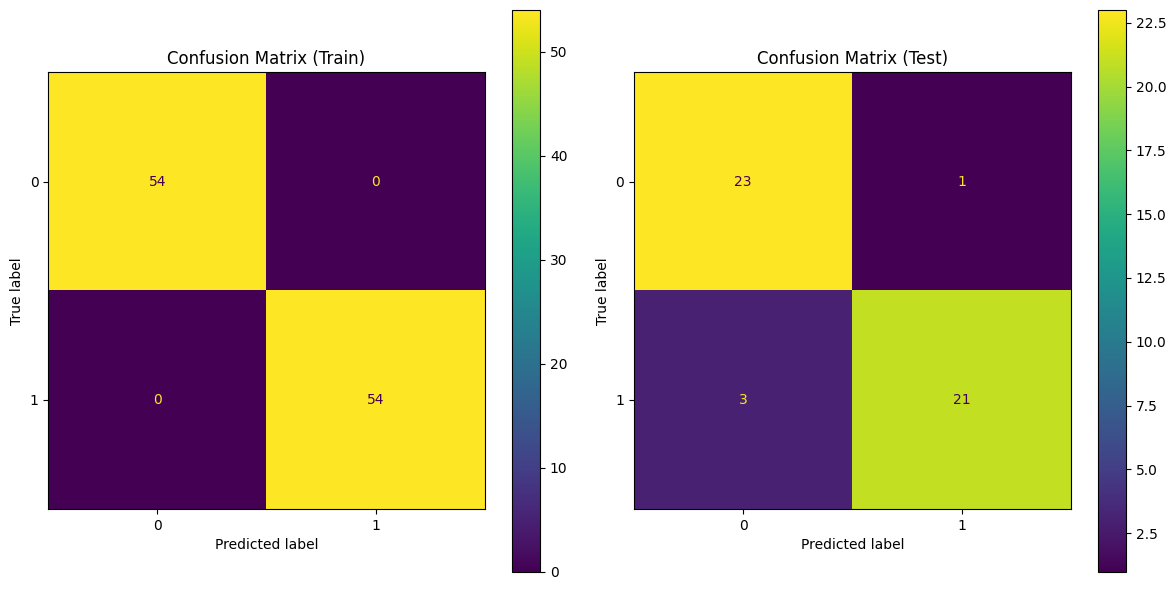

In [11]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(cm_train).plot(ax=ax[0], colorbar=True)
ax[0].set_title('Confusion Matrix (Train)')

ConfusionMatrixDisplay(cm_test).plot(ax=ax[1], colorbar=True)
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.show()

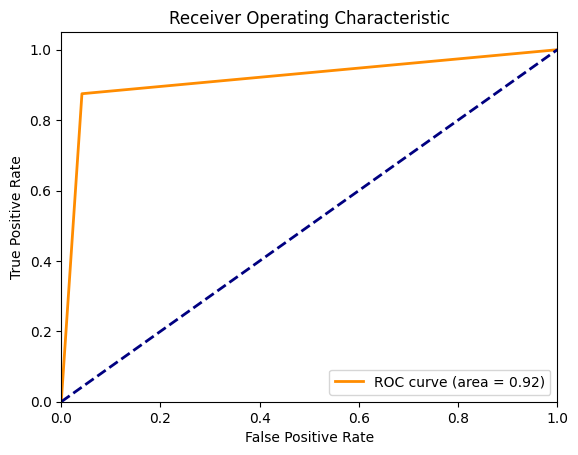

In [12]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

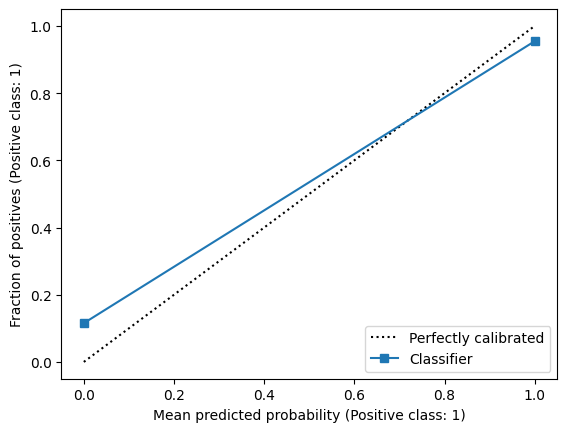

In [13]:
disp = CalibrationDisplay.from_predictions(y_test, y_pred_test)
plt.show()

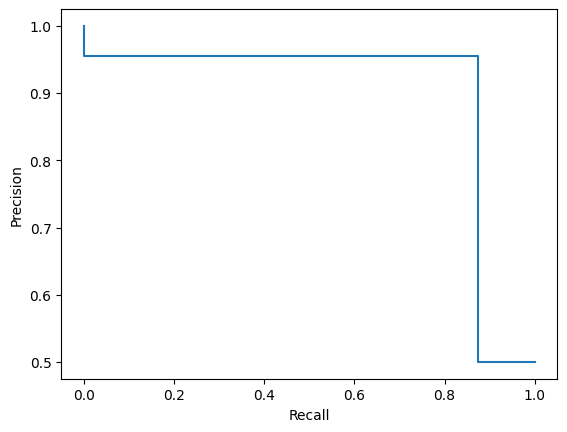

In [14]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()